### Imports
Import packages and load model parameters (uncertainties, levers, etc.)

In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pickle

In [3]:
# make sure pandas is version 1.0 or higher
# make sure networkx is verion 2.4 or higher
print(pd.__version__)
print(nx.__version__)

1.4.1
2.6.3


In [4]:
from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
    Samplers,
)
from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation import get_model_for_problem_formulation


def sum_over(*args):
    return sum(args)

In [5]:
# Enable logging
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

**Problem formulation**
Important cell below, here you can choose the problem formulation number, between 0-5
each problem formulation has its own list of outcomes

In [6]:
used_problem_formulation = 3

dike_model, planning_steps = get_model_for_problem_formulation(used_problem_formulation)

In [7]:
# enlisting uncertainties, their types (RealParameter/IntegerParameter/CategoricalParameter), lower boundary, and upper boundary
import copy

for unc in dike_model.uncertainties:
    print(repr(unc))

uncertainties = copy.deepcopy(dike_model.uncertainties)

CategoricalParameter('discount rate 0', [0, 1, 2, 3])
CategoricalParameter('discount rate 1', [0, 1, 2, 3])
CategoricalParameter('discount rate 2', [0, 1, 2, 3])
CategoricalParameter('A.1_Brate', [0, 1, 2])
CategoricalParameter('A.2_Brate', [0, 1, 2])
CategoricalParameter('A.3_Brate', [0, 1, 2])
CategoricalParameter('A.4_Brate', [0, 1, 2])
CategoricalParameter('A.5_Brate', [0, 1, 2])


In [8]:
# enlisting policy levers, their types (RealParameter/IntegerParameter), lower boundary, and upper boundary
for policy in dike_model.levers:
    print(repr(policy))

levers = copy.deepcopy(dike_model.levers)

In [9]:
# enlisting outcomes
for outcome in dike_model.outcomes:
    print(repr(outcome))

ScalarOutcome('A.1 Total Costs', variable_name=('A.1_Expected Annual Damage 0', 'A.1_Expected Annual Damage 1', 'A.1_Expected Annual Damage 2', 'A.1_Dike Investment Costs 0', 'A.1_Dike Investment Costs 1', 'A.1_Dike Investment Costs 2'), function=<function sum_over at 0x000002373987C9D0>)
ScalarOutcome('A.1_Expected Number of Deaths', variable_name=('A.1_Expected Number of Deaths 0', 'A.1_Expected Number of Deaths 1', 'A.1_Expected Number of Deaths 2'), function=<function sum_over at 0x000002373987C9D0>)
ScalarOutcome('A.2 Total Costs', variable_name=('A.2_Expected Annual Damage 0', 'A.2_Expected Annual Damage 1', 'A.2_Expected Annual Damage 2', 'A.2_Dike Investment Costs 0', 'A.2_Dike Investment Costs 1', 'A.2_Dike Investment Costs 2'), function=<function sum_over at 0x000002373987C9D0>)
ScalarOutcome('A.2_Expected Number of Deaths', variable_name=('A.2_Expected Number of Deaths 0', 'A.2_Expected Number of Deaths 1', 'A.2_Expected Number of Deaths 2'), function=<function sum_over at 0

### Policy formulations
In the following cells the wanted policies can be adjusted

In [10]:
# Create a function which sets everything to 0 by default
def get_0_dict():
    return {l.name: 0 for l in dike_model.levers}

# Creates a Policy object from a dict and a (optional) name
def create_policy(dict1, name=None):
    return Policy(f"Policy_{name}", **dict(get_0_dict(), **dict1))

In the following policies formulations:
- `RfR` says if the Room for River projects are enabled (projects `0` to `5`). The first number indicated the project, the second (after `RfR`) if in which time step the measure it taken (currently `0` to `2`). The value can be either `0` (not enabled) or `1` (enabled).
- `A.1` to `A.5` are the different dikes. `A.3` is the dike ring around Zutphen. The number after `DikeIncrease` is again the timestep, the value assigned to the thing the heightening in decimeters.
- Early Warning Systems can also be enabled, with `EWS_DaysToThreat`, which specifies the early warning time in days.

See the implementation in problem_formulation.py (starting from line 35) for more details.

In [11]:
pol_list = []
#pol_list.append(create_policy({}, name="Zero"))

for dm in [0, 10]:
    for location in [2]:
        for switch in [0,1]:
            for ews_days in [0, 4]:
                pol_list.append(create_policy({"A.3_DikeIncrease 0": dm, f"{location}_RfR 0": switch, "EWS_DaysToThreat": ews_days},
                                            name=f"Dike_{dm}dm_RfR_{location}{switch}_EWS_{ews_days}d"))


In [12]:
pol_list

[Policy({'0_RfR 0': 0, '0_RfR 1': 0, '0_RfR 2': 0, '1_RfR 0': 0, '1_RfR 1': 0, '1_RfR 2': 0, '2_RfR 0': 0, '2_RfR 1': 0, '2_RfR 2': 0, '3_RfR 0': 0, '3_RfR 1': 0, '3_RfR 2': 0, '4_RfR 0': 0, '4_RfR 1': 0, '4_RfR 2': 0, 'EWS_DaysToThreat': 0, 'A.1_DikeIncrease 0': 0, 'A.1_DikeIncrease 1': 0, 'A.1_DikeIncrease 2': 0, 'A.2_DikeIncrease 0': 0, 'A.2_DikeIncrease 1': 0, 'A.2_DikeIncrease 2': 0, 'A.3_DikeIncrease 0': 0, 'A.3_DikeIncrease 1': 0, 'A.3_DikeIncrease 2': 0, 'A.4_DikeIncrease 0': 0, 'A.4_DikeIncrease 1': 0, 'A.4_DikeIncrease 2': 0, 'A.5_DikeIncrease 0': 0, 'A.5_DikeIncrease 1': 0, 'A.5_DikeIncrease 2': 0}),
 Policy({'0_RfR 0': 0, '0_RfR 1': 0, '0_RfR 2': 0, '1_RfR 0': 0, '1_RfR 1': 0, '1_RfR 2': 0, '2_RfR 0': 0, '2_RfR 1': 0, '2_RfR 2': 0, '3_RfR 0': 0, '3_RfR 1': 0, '3_RfR 2': 0, '4_RfR 0': 0, '4_RfR 1': 0, '4_RfR 2': 0, 'EWS_DaysToThreat': 4, 'A.1_DikeIncrease 0': 0, 'A.1_DikeIncrease 1': 0, 'A.1_DikeIncrease 2': 0, 'A.2_DikeIncrease 0': 0, 'A.2_DikeIncrease 1': 0, 'A.2_DikeIncre

### Run the model (or load the data)
In the next cell the model is ran (if `use_pickle1 = False`) and the new results data is saved, or, if `use_pickle1 = True`, the saved results data is loaded.

In [13]:
# True, use results in pickle file; False, run MultiprocessingEvaluator
use_pickle1 = True

if use_pickle1:
    with open('data/formulation_results.pickle', 'rb') as filehandler:
        results = pickle.load(filehandler)

else:
    # pass the policies list to EMA workbench experiment runs
    n_scenarios = 15000
    with MultiprocessingEvaluator(dike_model, n_processes=10) as evaluator:
        results = evaluator.perform_experiments(n_scenarios, pol_list, uncertainty_sampling=Samplers.LHS)

    # Save results in Pickle file
    with open('data/policyresults.pickle', 'wb') as filehandler:
        pickle.dump(results, filehandler)

### Process the results
In this section a dataframe is generated with all the outcomes data, and aggegrated to mean, min, max and quantiles values for each policy.

In [14]:
# Create a dataframe from outcomes, and add the policy column to it
exp, out = results
df = pd.DataFrame(out)
a = df.columns[df.columns.str.contains('Costs')]
df['Total Costs'] = df[a].sum(axis=1)
a = df.columns[df.columns.str.contains('Deaths')]
df['Total Deaths'] = df[a].sum(axis=1)

#df["Total Costs"] = df[["Dike Investment Costs", "RfR Investment Costs", "Evacuation Costs"]].sum(axis=1)
#df["Cost plus Damage"] = df["Total Costs"] + df["Expected Annual Damage"]
df["policy"] = pd.DataFrame(exp)["policy"]
df

,A.1 Total Costs,A.1_Expected Number of Deaths,A.2 Total Costs,A.2_Expected Number of Deaths,A.3 Total Costs,A.3_Expected Number of Deaths,A.4 Total Costs,A.4_Expected Number of Deaths,A.5 Total Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs,Total Costs,Total Deaths,policy
0,1.640288e+07,0.016509,6.126701e+08,0.730318,0.000000e+00,0.000000,4.830969e+06,0.002911,0.000000e+00,0.000000,0.0,0.000000,6.339040e+08,0.749738,Policy_Dike_0dm_RfR_20_EWS_0d
1,3.056578e+09,1.978470,0.000000e+00,0.000000,0.000000e+00,0.000000,5.228778e+07,0.021473,4.724858e+08,0.371813,0.0,0.000000,3.581352e+09,2.371756,Policy_Dike_0dm_RfR_20_EWS_0d
2,0.000000e+00,0.000000,2.131622e+07,0.018399,7.277446e+07,0.117079,8.589175e+07,0.035237,8.232292e+08,0.626235,0.0,0.000000,1.003212e+09,0.796951,Policy_Dike_0dm_RfR_20_EWS_0d
3,3.498506e+09,1.968229,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.0,0.000000,3.498506e+09,1.968229,Policy_Dike_0dm_RfR_20_EWS_0d
4,2.847340e+09,1.979723,5.316239e+07,0.052730,1.602206e+09,2.828915,0.000000e+00,0.000000,0.000000e+00,0.000000,0.0,0.000000,4.502708e+09,4.861368,Policy_Dike_0dm_RfR_20_EWS_0d
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119995,2.893303e+09,0.236979,0.000000e+00,0.000000,4.421502e+07,0.000000,1.182268e+07,0.000609,0.000000e+00,0.000000,30700000.0,40134.689691,2.980081e+09,0.237587,Policy_Dike_10dm_RfR_21_EWS_4d
119996,3.176503e+09,0.234739,6.059762e+06,0.000633,4.421502e+07,0.000000,0.000000e+00,0.000000,1.087318e+07,0.001109,30700000.0,39924.430286,3.268391e+09,0.236480,Policy_Dike_10dm_RfR_21_EWS_4d
119997,3.206882e+09,0.237567,5.708215e+07,0.005839,4.421502e+07,0.000000,2.016471e+07,0.001041,0.000000e+00,0.000000,30700000.0,44213.549865,3.359088e+09,0.244446,Policy_Dike_10dm_RfR_21_EWS_4d
119998,0.000000e+00,0.000000,1.029811e+07,0.001448,4.421502e+07,0.000000,6.746776e+07,0.004574,0.000000e+00,0.000000,30700000.0,7667.009496,1.526886e+08,0.006022,Policy_Dike_10dm_RfR_21_EWS_4d


In [15]:
with open('data/policyresults.pickle', 'wb') as filehandler:
    pickle.dump(df, filehandler)

In [16]:
# Define two functions to get the 5th and 95th quantiles
def q05(x):
    return x.quantile(0.05)

def q95(x):
    return x.quantile(0.95)

In [17]:
runplot=False
if runplot==True:
    experiments, outcomes = results
    policies = experiments['policy']

    data = pd.DataFrame.from_dict(outcomes)
    data['policy'] = policies

    sns_plot = sns.pairplot(data, hue='policy',  vars=outcomes.keys(), )
    sns_plot.savefig('pairplot.png')
    plt.show()

In [37]:
if runplot==True:
    experiments, outcomes = results
    policies = experiments['policy']

    data = pd.DataFrame.from_dict(outcomes)
    data['policy'] = policies

    #a = data.columns[data.columns.str.contains('Costs')]
    #data['Total Costs'] = data[a].sum(axis=1)
    a = data.columns[data.columns.str.contains('Deaths')]
    data['Total Deaths'] = data[a].sum(axis=1)

    data_select = data.loc[data.policy.isin(['Policy_Dike_10dm_RfR_21_EWS_4d','Policy_Dike_10dm_RfR_20_EWS_4d', 'Policy_Dike_0dm_RfR_21_EWS_4d'])]

    #data_select.drop(['Total Costs', 'Total Deaths'], axis=1, inplace=True)

    sns_plot = sns.pairplot(data_select, hue='policy',  vars=outcomes.keys(), )
    sns_plot.savefig('pairplot_select.png')
    plt.show()

In [42]:
exp_select = exp.loc[exp.policy.isin(['Policy_Dike_10dm_RfR_21_EWS_4d','Policy_Dike_10dm_RfR_20_EWS_4d', 'Policy_Dike_0dm_RfR_21_EWS_4d'])]
exp_select.reset_index(inplace=True)
policies = exp['policy']
data = pd.DataFrame.from_dict(out)
data['policy'] = policies
out_select = data.loc[exp.policy.isin(['Policy_Dike_10dm_RfR_21_EWS_4d','Policy_Dike_10dm_RfR_20_EWS_4d', 'Policy_Dike_0dm_RfR_21_EWS_4d'])]
out_select.reset_index(inplace=True)
x= exp_select[['A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_Brate', 'A.1_pfail',
       'A.2_Bmax', 'A.2_Brate', 'A.2_pfail', 'A.3_Bmax', 'A.3_Brate',
       'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_pfail', 'A.5_Bmax',
       'A.5_Brate', 'A.5_pfail', 'discount rate 0', 'discount rate 1', 'policy']]
y=((out_select['A.3_Expected Number of Deaths'] >0) & (out_select['A.3 Total Costs'] >250000000))

In [39]:
out_select

,index,A.1 Total Costs,A.1_Expected Number of Deaths,A.2 Total Costs,A.2_Expected Number of Deaths,A.3 Total Costs,A.3_Expected Number of Deaths,A.4 Total Costs,A.4_Expected Number of Deaths,A.5 Total Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs,policy
0,45000,1.640288e+07,0.001981,3.976825e+08,0.057385,0.000000e+00,0.000000,7.702640e+06,0.000564,0.000000e+00,0.000000,30700000.0,37874.059931,Policy_Dike_0dm_RfR_21_EWS_4d
1,45001,3.056578e+09,0.237416,0.000000e+00,0.000000,0.000000e+00,0.000000,5.228778e+07,0.002577,4.724858e+08,0.044618,30700000.0,84868.239705,Policy_Dike_0dm_RfR_21_EWS_4d
2,45002,0.000000e+00,0.000000,6.891838e+06,0.000718,4.001747e+07,0.007679,8.650281e+07,0.004286,8.232292e+08,0.075148,30700000.0,66751.362884,Policy_Dike_0dm_RfR_21_EWS_4d
3,45003,3.498506e+09,0.236187,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,30700000.0,38932.152249,Policy_Dike_0dm_RfR_21_EWS_4d
4,45004,2.847340e+09,0.237567,2.634445e+07,0.003142,5.432905e+08,0.114771,0.000000e+00,0.000000,0.000000e+00,0.000000,30700000.0,74318.987585,Policy_Dike_0dm_RfR_21_EWS_4d
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,119995,2.893303e+09,0.236979,0.000000e+00,0.000000,4.421502e+07,0.000000,1.182268e+07,0.000609,0.000000e+00,0.000000,30700000.0,40134.689691,Policy_Dike_10dm_RfR_21_EWS_4d
44996,119996,3.176503e+09,0.234739,6.059762e+06,0.000633,4.421502e+07,0.000000,0.000000e+00,0.000000,1.087318e+07,0.001109,30700000.0,39924.430286,Policy_Dike_10dm_RfR_21_EWS_4d
44997,119997,3.206882e+09,0.237567,5.708215e+07,0.005839,4.421502e+07,0.000000,2.016471e+07,0.001041,0.000000e+00,0.000000,30700000.0,44213.549865,Policy_Dike_10dm_RfR_21_EWS_4d
44998,119998,0.000000e+00,0.000000,1.029811e+07,0.001448,4.421502e+07,0.000000,6.746776e+07,0.004574,0.000000e+00,0.000000,30700000.0,7667.009496,Policy_Dike_10dm_RfR_21_EWS_4d


In [43]:
from ema_workbench.analysis import (prim, dimensional_stacking)
from ema_workbench import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO)

#ik heb peel-alpha weggehaald, maar dat is misschien niet helemaal correct?
prim_alg = prim.Prim(x, y, threshold=0.7)
box1 = prim_alg.find_box()

[MainProcess/INFO] 45000 points remaining, containing 2879 cases of interest
[MainProcess/INFO] mean: 0.9253921153030945, mass: 0.052422222222222224, coverage: 0.758249392150052, density: 0.9253921153030945 restricted_dimensions: 4


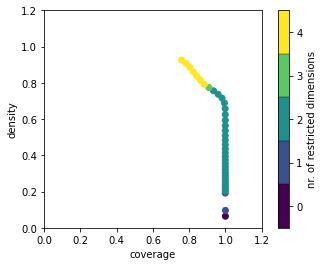

In [44]:
box1.show_tradeoff()
plt.show()

In [46]:
box1.inspect_tradeoff()

alt.VConcatChart(...)

c:\Users\hanna\Anaconda3\envs\simmaster\lib\site-packages\ema_workbench\analysis\scenario_discovery_util.py:419: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)


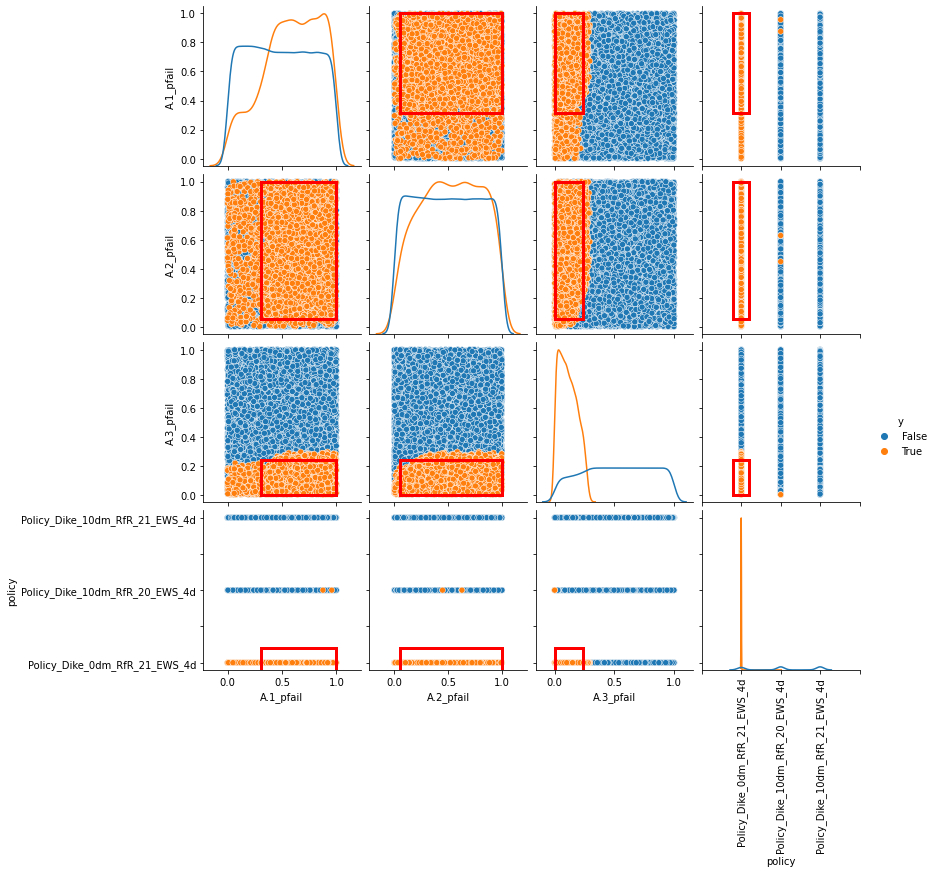

In [47]:
box1.show_pairs_scatter()
plt.show()

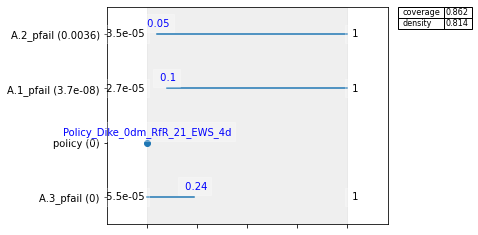

In [49]:
box1.inspect(33, style='graph')
plt.show()

c:\Users\hanna\Anaconda3\envs\simmaster\lib\site-packages\ema_workbench\analysis\dimensional_stacking.py:423: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ooi = pd.DataFrame(y[:, np.newaxis], columns=[ooi_label])


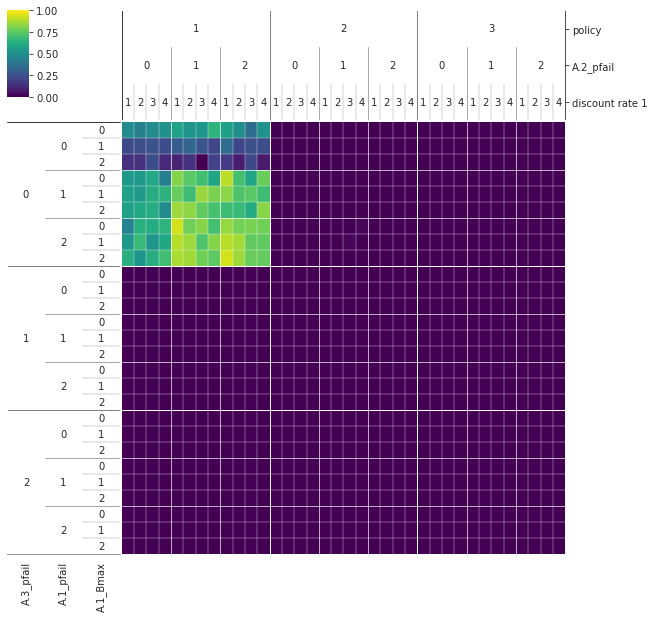

In [45]:
dimensional_stacking.create_pivot_plot(x, y)
plt.show()

In [ ]:
# Create a Pandas GroupBy object
group_df = df.groupby(by="policy")

# Create a list of statistical functions which are used
agg_par = ["mean", "min", "max", q05, q95]

# Create a dictionary with what outcome values are aggegrated with which functions
agg_dict = {
    "A.3_Expected Number of Deaths": agg_par,
    "Total Deaths": agg_par,
    "Total Costs": "mean"
}
# Create new dataframe with the aggegrated data per policy
TCA_df = group_df.agg(agg_dict)
TCA_df

A.3_Expected Number of Deaths                 \
                                                        mean  min       max   
policy                                                                        
Policy_Dike_0dm_RfR_20_EWS_0d                       0.741388  0.0  3.674402   
Policy_Dike_0dm_RfR_20_EWS_4d                       0.088967  0.0  0.440928   
Policy_Dike_0dm_RfR_21_EWS_0d                       0.418387  0.0  3.373683   
Policy_Dike_0dm_RfR_21_EWS_4d                       0.050206  0.0  0.404842   
Policy_Dike_10dm_RfR_20_EWS_0d                      0.000184  0.0  0.734920   
Policy_Dike_10dm_RfR_20_EWS_4d                      0.000022  0.0  0.088190   
Policy_Dike_10dm_RfR_21_EWS_0d                      0.000050  0.0  0.188866   
Policy_Dike_10dm_RfR_21_EWS_4d                      0.000006  0.0  0.022664   

                                              Total Deaths            \
                                q05       q95         mean       min   
policy                                                                 
Policy_Dike_0dm_RfR_20_EWS_0d   0.0  3.569302     1.733062  0.032576   
Policy_Dike_0dm_RfR_20_EWS_4d   0.0  0.428316     0.207967  0.003909   
Policy_Dike_0dm_RfR_21_EWS_0d   0.0  3.216381     1.392718  0.018100   
Policy_Dike_0dm_RfR_21_EWS_4d   0.0  0.385966     0.167126  0.002172   
Policy_Dike_10dm_RfR_20_EWS_0d  0.0  0.000000     1.017725  0.005406   
Policy_Dike_10dm_RfR_20_EWS_4d  0.0  0.000000     0.122127  0.000649   
Policy_Dike_10dm_RfR_21_EWS_0d  0.0  0.000000     0.991069  0.001905   
Policy_Dike_10dm_RfR_21_EWS_4d  0.0  0.000000     0.118928  0.000229   

                                                               Total Costs  
                                     max       q05       q95          mean  
policy                                                                      
Policy_Dike_0dm_RfR_20_EWS_0d   6.029205  0.180143  4.055579  1.816915e+09  
Policy_Dike_0dm_RfR_20_EWS_4d   0.723505  0.021617  0.486670  1.816973e+09  
Policy_Dike_0dm_RfR_21_EWS_0d   5.965603  0.128091  3.474850  1.652230e+09  
Policy_Dike_0dm_RfR_21_EWS_4d   0.715872  0.015371  0.416982  1.652277e+09  
Policy_Dike_10dm_RfR_20_EWS_0d  3.305936  0.072736  2.092183  1.466899e+09  
Policy_Dike_10dm_RfR_20_EWS_4d  0.396712  0.008728  0.251062  1.466935e+09  
Policy_Dike_10dm_RfR_21_EWS_0d  3.081765  0.063531  2.066755  1.470042e+09  
Policy_Dike_10dm_RfR_21_EWS_4d  0.369812  0.007624  0.248011  1.470076e+09

In [ ]:
# Save the aggegrated data to a CSV file
TCA_df.to_csv(f"results/TCA_results_pf{used_problem_formulation}.csv")

In [ ]:
TCA_df.columns

MultiIndex([('A.3_Expected Number of Deaths', 'mean'),
            ('A.3_Expected Number of Deaths',  'min'),
            ('A.3_Expected Number of Deaths',  'max'),
            ('A.3_Expected Number of Deaths',  'q05'),
            ('A.3_Expected Number of Deaths',  'q95'),
            (                 'Total Deaths', 'mean'),
            (                 'Total Deaths',  'min'),
            (                 'Total Deaths',  'max'),
            (                 'Total Deaths',  'q05'),
            (                 'Total Deaths',  'q95'),
            (                  'Total Costs', 'mean')],
           )

### Plots

TODO: Make make some nice Seaborn plots?

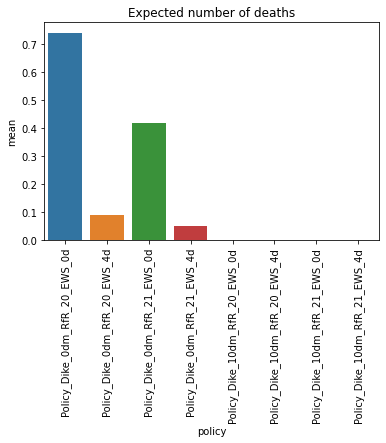

<Figure size 432x288 with 0 Axes>

In [ ]:
#TCA_df["Expected Number of Deaths"]["mean"].plot.bar()
ND = sns.barplot(x= TCA_df.index , y = TCA_df["A.3_Expected Number of Deaths"]["mean"], data = TCA_df)
ND.set(title='Expected number of deaths')
#ND.fig.suptitle('Expected number of deaths')
plt.xticks(rotation=90)
plt.show()
plt.savefig('number of deaths.png')

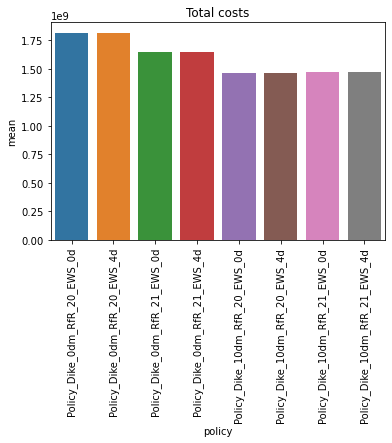

<Figure size 432x288 with 0 Axes>

In [ ]:
#TCA_df["Total Costs"]["mean"].plot.bar()
TC = sns.barplot(x= TCA_df.index , y = TCA_df["Total Costs"]["mean"], data = TCA_df)
TC.set(title='Total costs')
plt.xticks(rotation=90)
plt.show()
plt.savefig('total costs.png')

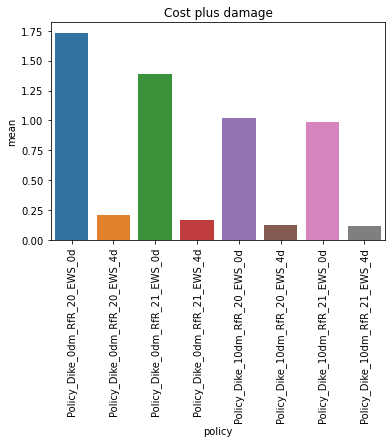

<Figure size 432x288 with 0 Axes>

In [ ]:
#TCA_df["Cost plus Damage"]["mean"].plot.bar()
CpD = sns.barplot(x= TCA_df.index , y = TCA_df["Total Deaths"]["mean"], data = TCA_df)
CpD.set(title='Cost plus damage')
plt.xticks(rotation=90)
plt.show()
plt.savefig('totaldeaths.png')

Scenario selectie

In [ ]:
df

,A.1 Total Costs,A.1_Expected Number of Deaths,A.2 Total Costs,A.2_Expected Number of Deaths,A.3 Total Costs,A.3_Expected Number of Deaths,A.4 Total Costs,A.4_Expected Number of Deaths,A.5 Total Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs,Total Costs,Total Deaths,policy
0,1.640288e+07,0.016509,6.126701e+08,0.730318,0.000000e+00,0.000000,4.830969e+06,0.002911,0.000000e+00,0.000000,0.0,0.000000,6.339040e+08,0.749738,Policy_Dike_0dm_RfR_20_EWS_0d
1,3.056578e+09,1.978470,0.000000e+00,0.000000,0.000000e+00,0.000000,5.228778e+07,0.021473,4.724858e+08,0.371813,0.0,0.000000,3.581352e+09,2.371756,Policy_Dike_0dm_RfR_20_EWS_0d
2,0.000000e+00,0.000000,2.131622e+07,0.018399,7.277446e+07,0.117079,8.589175e+07,0.035237,8.232292e+08,0.626235,0.0,0.000000,1.003212e+09,0.796951,Policy_Dike_0dm_RfR_20_EWS_0d
3,3.498506e+09,1.968229,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.0,0.000000,3.498506e+09,1.968229,Policy_Dike_0dm_RfR_20_EWS_0d
4,2.847340e+09,1.979723,5.316239e+07,0.052730,1.602206e+09,2.828915,0.000000e+00,0.000000,0.000000e+00,0.000000,0.0,0.000000,4.502708e+09,4.861368,Policy_Dike_0dm_RfR_20_EWS_0d
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119995,2.893303e+09,0.236979,0.000000e+00,0.000000,4.421502e+07,0.000000,1.182268e+07,0.000609,0.000000e+00,0.000000,30700000.0,40134.689691,2.980081e+09,0.237587,Policy_Dike_10dm_RfR_21_EWS_4d
119996,3.176503e+09,0.234739,6.059762e+06,0.000633,4.421502e+07,0.000000,0.000000e+00,0.000000,1.087318e+07,0.001109,30700000.0,39924.430286,3.268391e+09,0.236480,Policy_Dike_10dm_RfR_21_EWS_4d
119997,3.206882e+09,0.237567,5.708215e+07,0.005839,4.421502e+07,0.000000,2.016471e+07,0.001041,0.000000e+00,0.000000,30700000.0,44213.549865,3.359088e+09,0.244446,Policy_Dike_10dm_RfR_21_EWS_4d
119998,0.000000e+00,0.000000,1.029811e+07,0.001448,4.421502e+07,0.000000,6.746776e+07,0.004574,0.000000e+00,0.000000,30700000.0,7667.009496,1.526886e+08,0.006022,Policy_Dike_10dm_RfR_21_EWS_4d


In [ ]:
adf=df.iloc[:,:-1]
adf.idxmax()

A.1 Total Costs                  13306
A.1_Expected Number of Deaths      452
A.2 Total Costs                   8934
A.2_Expected Number of Deaths     6035
A.3 Total Costs                   9898
A.3_Expected Number of Deaths       31
A.4 Total Costs                  40073
A.4_Expected Number of Deaths    32922
A.5 Total Costs                  36605
A.5_Expected Number of Deaths    93334
RfR Total Costs                  30000
Expected Evacuation Costs        29992
Total Costs                      26265
Total Deaths                     14263
dtype: int64

In [ ]:
adf.idxmin()

A.1 Total Costs                       2
A.1_Expected Number of Deaths         2
A.2 Total Costs                       1
A.2_Expected Number of Deaths         1
A.3 Total Costs                       0
A.3_Expected Number of Deaths         0
A.4 Total Costs                       3
A.4_Expected Number of Deaths         3
A.5 Total Costs                       0
A.5_Expected Number of Deaths         0
RfR Total Costs                       0
Expected Evacuation Costs             0
Total Costs                       14519
Total Deaths                     117637
dtype: int64

In [ ]:
exp.columns

Index(['A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_Brate', 'A.1_pfail',
       'A.2_Bmax', 'A.2_Brate', 'A.2_pfail', 'A.3_Bmax', 'A.3_Brate',
       'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_pfail', 'A.5_Bmax',
       'A.5_Brate', 'A.5_pfail', 'discount rate 0', 'discount rate 1',
       'discount rate 2', '0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0',
       '1_RfR 1', '1_RfR 2', '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0',
       '3_RfR 1', '3_RfR 2', '4_RfR 0', '4_RfR 1', '4_RfR 2',
       'EWS_DaysToThreat', 'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1',
       'A.1_DikeIncrease 2', 'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1',
       'A.2_DikeIncrease 2', 'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1',
       'A.3_DikeIncrease 2', 'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1',
       'A.4_DikeIncrease 2', 'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1',
       'A.5_DikeIncrease 2', 'scenario', 'policy', 'model'],
      dtype='object')

In [ ]:
from ema_workbench import Scenario
# also all we need are the uncertainty columns
selected = experiments.loc[[0, 14519, 117637, 31, 26265, 14263, 9898], ['A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_Brate', 'A.1_pfail',
       'A.2_Bmax', 'A.2_Brate', 'A.2_pfail', 'A.3_Bmax', 'A.3_Brate',
       'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_pfail', 'A.5_Bmax',
       'A.5_Brate', 'A.5_pfail', 'discount rate 0', 'discount rate 1',
       'discount rate 2']]
selected
scenarios = [Scenario(f"{index}", **row) for index, row in selected.iterrows()]

In [ ]:
with open('data/scenariosselection.pickle', 'wb') as filehandler:
    pickle.dump(scenarios, filehandler)